# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Original Dataset Description](##1-original-dataset-description-cmems-global_multiyear_phy_001_030)
2. [Data Engineering](#2-data-engineering)
3. [Final Dataset Description](#3-final-dataset-overview)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean


## 1. Original Dataset Description: CMEMS GLOBAL_MULTIYEAR_PHY_001_030

The primary data source for this study is the **Copernicus Marine Environment Monitoring Service (CMEMS) Global Ocean Physics Reanalysis (GLORYS12V1)**. This product provides a numerical reconstruction of the 3D physics of the global ocean, generated by the **NEMO** (Nucleus for European Modelling of the Ocean) platform. 

It utilizes a $1/12^\circ$ ($\approx 8.3 \text{ km}$) eddy-resolving horizontal grid with 50 standard vertical levels. Unlike raw satellite products, this reanalysis assimilates satellite altimetry, sea surface temperature, and sea ice concentration, along with *in-situ* temperature and salinity profiles, ensuring physical consistency across variables.

### 1.1 Spatial and Temporal Domain
The dataset is subsetted to focus on the **North West African Upwelling Region**, a dynamically active area characterized by intense mesoscale activity and filaments.

| Parameter | Specification |
| :--- | :--- |
| **Geographic Bounds** | $32.50^\circ \text{W}$ to $11.50^\circ \text{W}$ / $5.00^\circ \text{N}$ to $26.00^\circ \text{N}$ |
| **Temporal Range** | January 1, 2000 – December 23, 2025 |
| **Temporal Resolution** | Daily-mean outputs |
| **Total Duration** | 25 Years (9,489 time steps) |

### 1.2 Model Variables
The emulator utilizes one surface variable extracted at the **$0.49\text{m}$** depth level:

* **Potential Temperature ($\theta_o$):** Representing the upper-layer heat content.


In [ ]:
import os

# Path to the CMEMS GLORYS12V1 NetCDF file (daily SST, 253x253).
# Update this to point to your local copy of the dataset.
DATA_DIR = os.path.join('..', 'data')
file_path = os.path.join(DATA_DIR, 'CMEMS_thetao_daily.nc')

sst_ds = xr.open_dataset(file_path)['thetao']


In [ ]:
print(sst_ds)


<xarray.DataArray 'thetao' (time: 9489, depth: 1, latitude: 253, longitude: 253)> Size: 5GB
[607381401 values with dtype=float64]
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 1kB 5.0 5.083 5.167 5.25 ... 25.83 25.92 26.0
  * longitude  (longitude) float32 1kB -32.5 -32.42 -32.33 ... -11.58 -11.5
  * time       (time) datetime64[ns] 76kB 2000-01-01 2000-01-02 ... 2025-12-23
Attributes:
    units:          degrees_C
    long_name:      Temperature
    unit_long:      Degrees Celsius
    standard_name:  sea_water_potential_temperature
    valid_max:      21306
    valid_min:      -32766


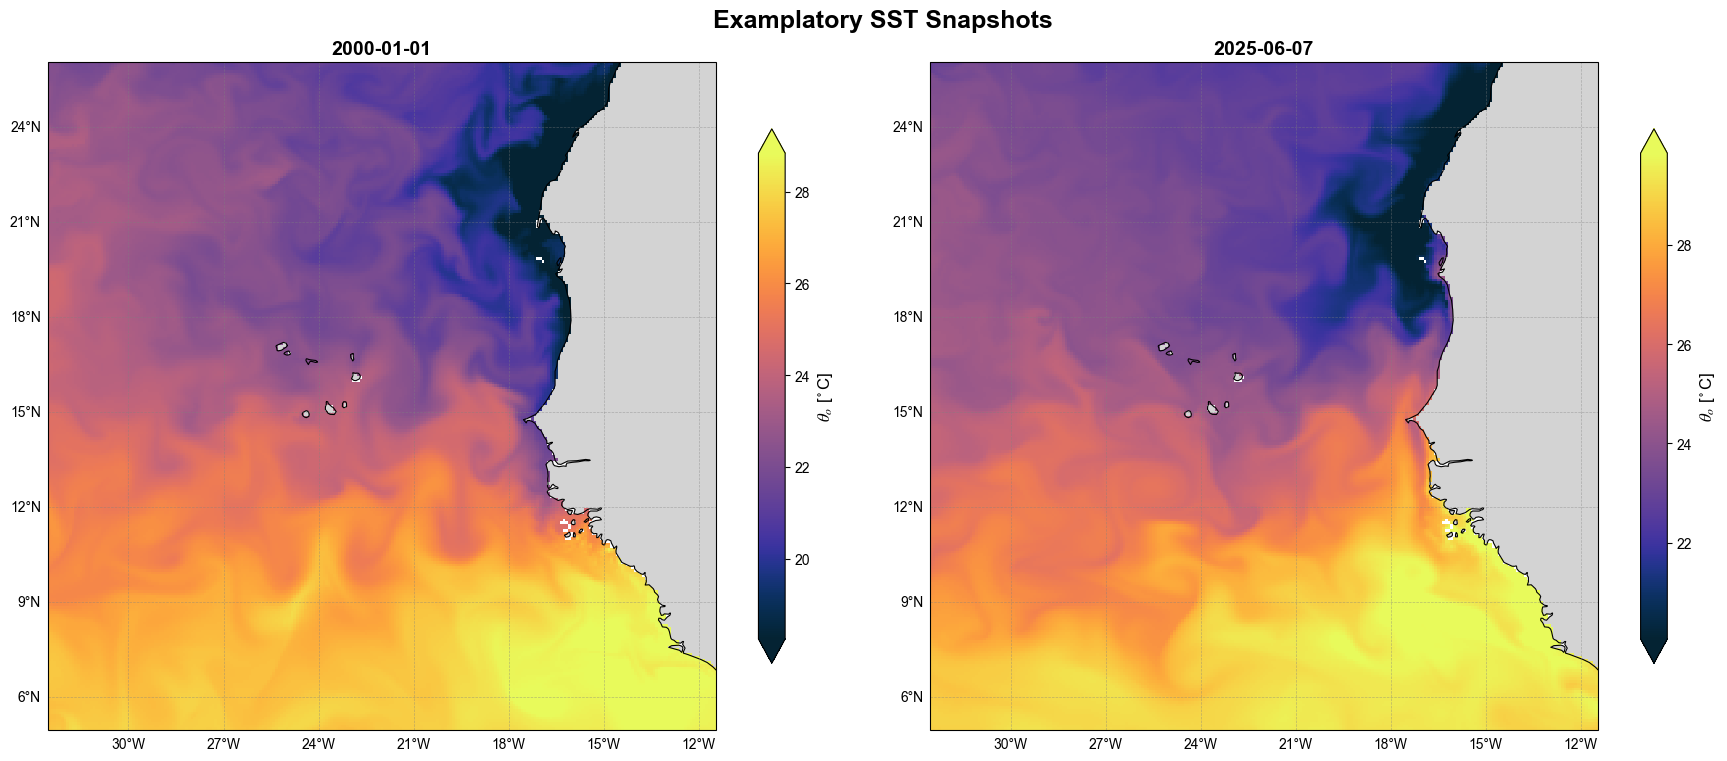

In [ ]:
# 1. Select the specific days
first_day = sst_ds.isel(time=0)
last_day = sst_ds.isel(time=-200)

# 2. Plotting Configuration
fig, axs = plt.subplots(1, 2, figsize=(18, 8), 
                        subplot_kw={'projection': ccrs.PlateCarree()})

# Formatting helper for the snapshots
days = [first_day, last_day]
titles = [f"{first_day.time.dt.strftime('%Y-%m-%d').values}", 
          f"{last_day.time.dt.strftime('%Y-%m-%d').values}"]

for i, ax in enumerate(axs):
    # Plot data
    im = days[i].plot(ax=ax, transform=ccrs.PlateCarree(),
                      cmap=cmocean.cm.thermal, 
                      cbar_kwargs={'label': r'$\theta_o$ [$^\circ$C]', 'shrink': 0.8},
                      robust=True)
    
    # Cartography
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_title(titles[i], fontweight='bold', fontsize=14)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.suptitle("Exemplary SST Snapshots", 
             fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2. Data Engineering

To prepare the CMEMS GLORYS12V1 dataset for the surface emulator, two primary spatial and temporal transformations were applied to balance physical fidelity with computational efficiency.

* The original daily-mean outputs were downsampled to a **weekly temporal resolution** by calculating the arithmetic mean of each 7-day window.
* The native $1/12^\circ$ grid ($253 \times 253$ pixels for the selected domain) was upsampled to a uniform **$512 \times 512$ grid** using **bilinear interpolation**.

| Transformation | Original Shape | Target Shape | Method |
| :--- | :--- | :--- | :--- |
| **Temporal** | Daily (9,489 steps) | Weekly (1,357 steps) | Mean Aggregation |
| **Spatial** | $253 \times 253$ px | $512 \times 512$ px | Bilinear Interpolation |


In [ ]:
sst_ds_weekly = sst_ds.resample(time='7D').mean()


In [ ]:
lat_interp = np.arange(np.float64(sst_ds.latitude.min()), np.float64(sst_ds.latitude.max()), 512)
lon_interp = np.arange(np.float64(sst_ds.longitude.min()), np.float64(sst_ds.longitude.max()), 512)


In [ ]:
sst_ds_weekly_interp = sst_ds_weekly.interp(latitude=lat_interp, longitude=lon_interp, method='linear')


# 3. Final Dataset Overview


In [ ]:
print(sst_ds_weekly_interp)


<xarray.DataArray 'thetao' (time: 1357, latitude: 512, longitude: 512)> Size: 3GB
[355729408 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 11kB 2000-01-02 2000-01-09 ... 2025-12-28
  * latitude   (latitude) float64 4kB 5.0 5.041 5.082 5.123 ... 25.92 25.96 26.0
  * longitude  (longitude) float64 4kB -32.5 -32.46 -32.42 ... -11.54 -11.5
Attributes:
    units:          degrees_C
    long_name:      Temperature
    unit_long:      Degrees Celsius
    standard_name:  sea_water_potential_temperature
    valid_max:      21306
    valid_min:      -32766


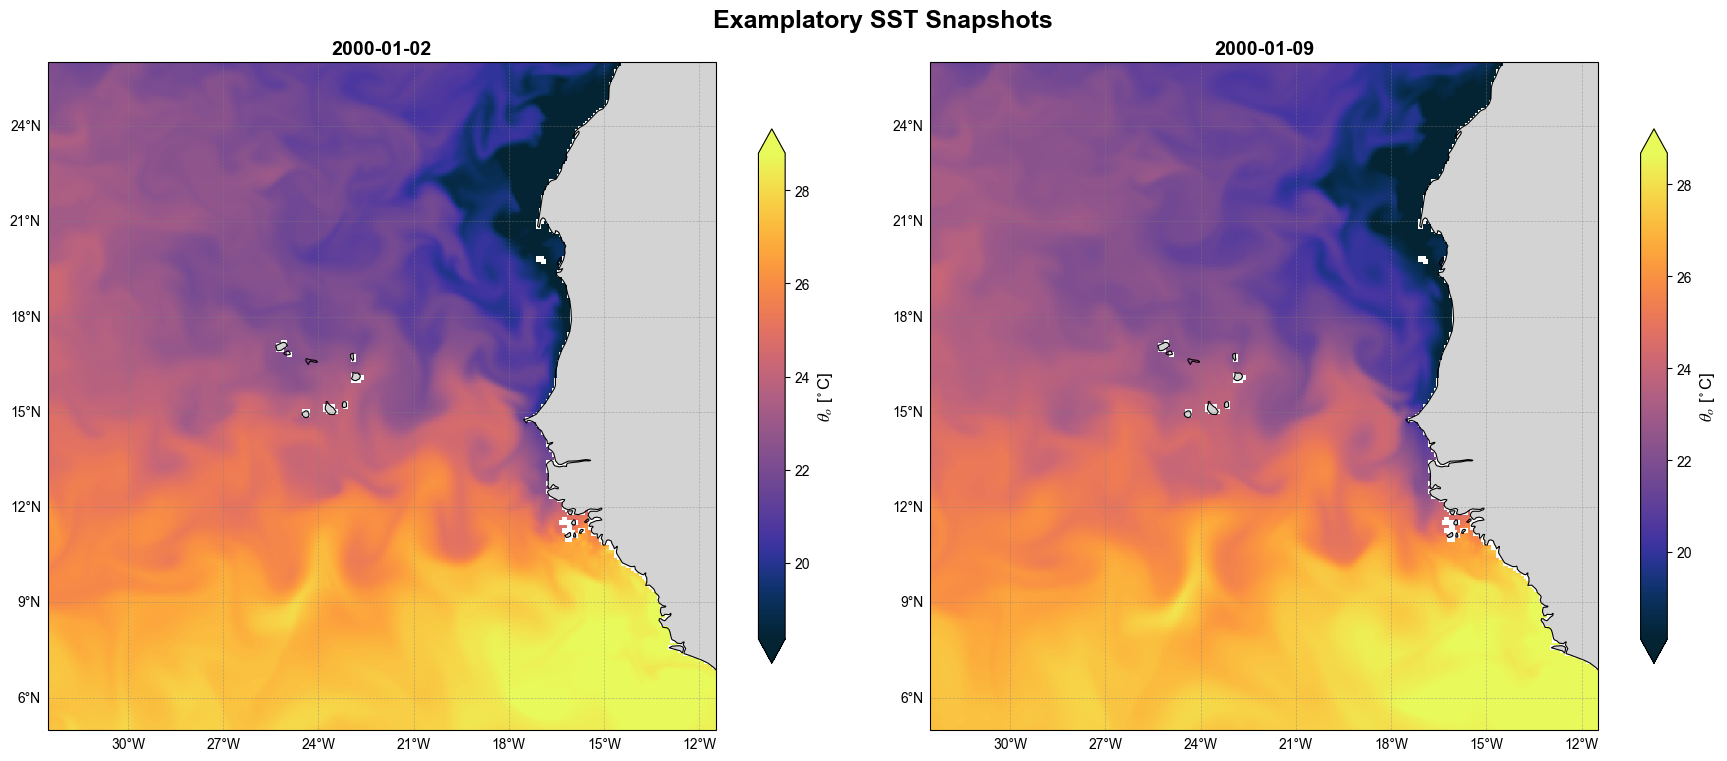

In [ ]:
# 1. Select the specific days
first_day = sst_ds_weekly_interp.isel(time=0)
last_day = sst_ds_weekly_interp.isel(time=1)

# 2. Plotting Configuration
fig, axs = plt.subplots(1, 2, figsize=(18, 8), 
                        subplot_kw={'projection': ccrs.PlateCarree()})

# Formatting helper for the snapshots
days = [first_day, last_day]
titles = [f"{first_day.time.dt.strftime('%Y-%m-%d').values}", 
          f"{last_day.time.dt.strftime('%Y-%m-%d').values}"]

for i, ax in enumerate(axs):
    # Plot data
    im = days[i].plot(ax=ax, transform=ccrs.PlateCarree(),
                      cmap=cmocean.cm.thermal, 
                      cbar_kwargs={'label': r'$\theta_o$ [$^\circ$C]', 'shrink': 0.8},
                      robust=True)
    
    # Cartography
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_title(titles[i], fontweight='bold', fontsize=14)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.suptitle("Examplatory SST Snapshots", 
             fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
print('Mean SST (°C):', np.round(sst_ds_weekly_interp.mean().values, 2))
print('SST Standard Deviation (°C):', np.round(sst_ds_weekly_interp.std().values, 2))


Mean SST (°C): 25.41
SST Standard Deviation (°C): 2.67
